In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_blobs
import matplotlib.animation as animation
from IPython.display import HTML

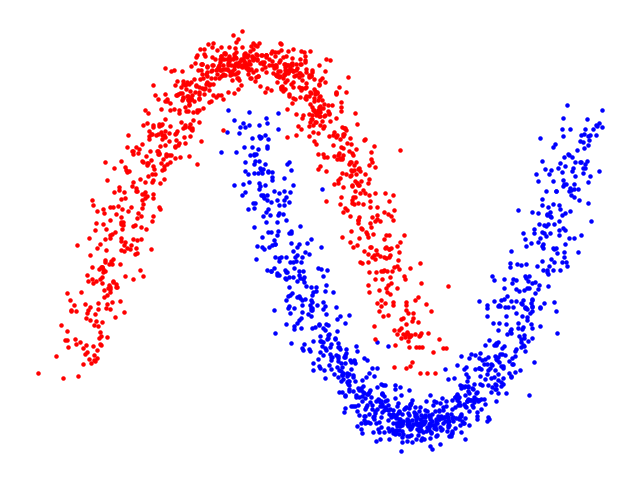

In [ ]:
def generate_data(b1 = 0, b2 = 3, c1 = 0, c2 = 11, xl1 = -3, xl2 = 0, yl1 = 3, yl2 = 6):
  # Параметры для парабол:
  # Высота ветвей, большие значения сломают фигуру
  a1 = 1
  a2 = -1

  # Диапазон для случайных точек
  x_range = (-7, 7)
  y_range = (-6, 14)

  # Ограничение длинны ветвей
  x1_range = (xl1, yl1)  # Диапазон x для первой параболы
  x2_range = (xl2, yl2)  # Диапазон x для второй параболы

  # Увеличение расстояния между параболами
  xl2 = -7  # Сдвиг начала второй параболы влево

  # Генерация точек для первой параболы
  x1 = np.linspace(x1_range[0], x1_range[1], 100)
  y1 = a1 * (x1 - b1) ** 2 + c1

  # Генерация точек для второй параболы
  x2 = np.linspace(x2_range[0], x2_range[1], 100)
  y2 = a2 * (x2 - b2) ** 2 + c2

  # Отзеркаливание второй параболы по оси y
  x2_mirror = -x2
  y2_mirror = y2

  # Создание массивов точек для make_blobs
  X1_base = np.column_stack((x1, y1))
  X2_base = np.column_stack((x2_mirror, y2_mirror))

  # Генерация случайных точек вокруг базовых точек
  n_samples = 1000  # Увеличение количества точек до 1000
  cluster_std = 0.2  # Уменьшение стандартного отклонения до 0.2

  # Вводим случайные изменения в параметры make_blobs
  random_state = np.random.randint(100)  # Случайное начальное состояние генератора
  cluster_std_variation = np.random.uniform(0.05, 0.2)  # Уменьшение диапазона изменения стандартного отклонения

  X1, _ = make_blobs(n_samples=n_samples, centers=X1_base, cluster_std=cluster_std + cluster_std_variation, random_state=random_state)
  X2, _ = make_blobs(n_samples=n_samples, centers=X2_base, cluster_std=cluster_std + cluster_std_variation, random_state=random_state)

  # Объединение данных и меток (0 для первой параболы, 1 для второй)
  X = np.concatenate((X1, X2))
  y = np.concatenate((np.zeros(len(X1)), np.ones(len(X2))))

  # Перемешивание точек внутри каждого кластера
  for i in range(2):  # Для каждого кластера
    indices = np.where(y == i)[0]  # Индексы точек в кластере
    permutation = np.random.permutation(len(indices))  # Перестановка индексов
    X[indices] = X[indices[permutation]]  # Перемешивание точек в кластере

  # Отрисовка точек
  plt.figure(figsize=(8, 6))
  plt.scatter(X[y == 0, 0], X[y == 0, 1], s=5, c='blue', label='Парабола 1')
  plt.scatter(X[y == 1, 0], X[y == 1, 1], s=5, c='red', label='Парабола 2')

  plt.axis('off')
  plt.show()

  return X, y

X, y = generate_data()

Epoch 10, Loss: 0.5587
Epoch 20, Loss: 0.5261
Epoch 30, Loss: 0.5071
Epoch 40, Loss: 0.4932
Epoch 50, Loss: 0.4803
Epoch 60, Loss: 0.4686
Epoch 70, Loss: 0.4585
Epoch 80, Loss: 0.4498
Epoch 90, Loss: 0.4422
Epoch 100, Loss: 0.4354
Число нейронов: 2, Точность: 0.0000
Epoch 10, Loss: 0.7942
Epoch 20, Loss: 0.6849
Epoch 30, Loss: 0.6138
Epoch 40, Loss: 0.5644
Epoch 50, Loss: 0.5283
Epoch 60, Loss: 0.5018
Epoch 70, Loss: 0.4827
Epoch 80, Loss: 0.4688
Epoch 90, Loss: 0.4581
Epoch 100, Loss: 0.4495
Число нейронов: 5, Точность: 0.0000
Epoch 10, Loss: 0.6241
Epoch 20, Loss: 0.5292
Epoch 30, Loss: 0.4958
Epoch 40, Loss: 0.4810
Epoch 50, Loss: 0.4714
Epoch 60, Loss: 0.4634
Epoch 70, Loss: 0.4560
Epoch 80, Loss: 0.4492
Epoch 90, Loss: 0.4430
Epoch 100, Loss: 0.4371
Число нейронов: 10, Точность: 0.0000
Epoch 10, Loss: 0.5074
Epoch 20, Loss: 0.4797
Epoch 30, Loss: 0.4654
Epoch 40, Loss: 0.4538
Epoch 50, Loss: 0.4449
Epoch 60, Loss: 0.4379
Epoch 70, Loss: 0.4316
Epoch 80, Loss: 0.4254
Epoch 90, Loss

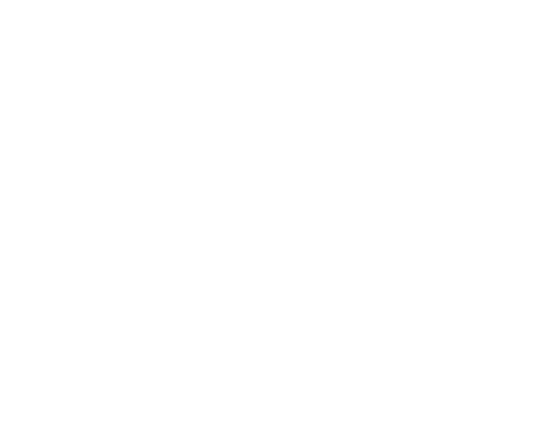

In [ ]:
class RBF(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RBF, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Обучаемые параметры
        self.centers = nn.Parameter(torch.randn(hidden_dim, input_dim))
        self.gammas = nn.Parameter(torch.ones(hidden_dim))  # Ширина RBF, обучаемая
        self.weights = nn.Parameter(torch.randn(hidden_dim, output_dim))

        # Линейный слой для выходного слоя
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Ensure input data type is float
        if isinstance(x, torch.Tensor):
            x = x.float()
        else:
            # Преобразование массива NumPy в тензор PyTorch
            x = torch.from_numpy(x).float()

        # Calculate distance between input data and RBF function centers
        distances = torch.cdist(x, self.centers)

        # Calculate RBF function activations
        activations = torch.exp(-(distances * distances) / (2 * self.gammas * self.gammas))

        # Linear combination of activations to get output
        output = self.linear(activations)
        return output

  # Генерация данных
def generate_data(b1 = 0, b2 = 3, c1 = 0, c2 = 11, xl1 = -3, xl2 = 0, yl1 = 3, yl2 = 6):
  # Параметры для парабол:
  # Высота ветвей, большие значения сломают фигуру
  a1 = 1
  a2 = -1
  # Диапазон для случайных точек
  x_range = (-7, 7)
  y_range = (-6, 14)
  # Ограничение длинны ветвей
  x1_range = (xl1, yl1)  # Диапазон x для первой параболы
  x2_range = (xl2, yl2)  # Диапазон x для второй параболы
  # Увеличение расстояния между параболами
  xl2 = -7  # Сдвиг начала второй параболы влево
  # Генерация точек для первой параболы
  x1 = np.linspace(x1_range[0], x1_range[1], 100)
  y1 = a1 * (x1 - b1) ** 2 + c1
  # Генерация точек для второй параболы
  x2 = np.linspace(x2_range[0], x2_range[1], 100)
  y2 = a2 * (x2 - b2) ** 2 + c2
  # Отзеркаливание второй параболы по оси y
  x2_mirror = -x2
  y2_mirror = y2
  # Создание массивов точек для make_blobs
  X1_base = np.column_stack((x1, y1))
  X2_base = np.column_stack((x2_mirror, y2_mirror))
  # Генерация случайных точек вокруг базовых точек
  n_samples = 1000  # Увеличение количества точек до 1000
  cluster_std = 0.2  # Уменьшение стандартного отклонения до 0.2

  # Вводим случайные изменения в параметры make_blobs
  random_state = np.random.randint(100)  # Случайное начальное состояние генератора
  cluster_std_variation = np.random.uniform(0.05, 0.2)  # Уменьшение диапазона изменения стандартного отклонения

  X1, _ = make_blobs(n_samples=n_samples, centers=X1_base, cluster_std=cluster_std + cluster_std_variation, random_state=random_state)
  X2, _ = make_blobs(n_samples=n_samples, centers=X2_base, cluster_std=cluster_std + cluster_std_variation, random_state=random_state)

  # Объединение данных и меток (0 для первой параболы, 1 для второй)
  X = np.concatenate((X1, X2))
  y = np.concatenate((np.zeros(len(X1)), np.ones(len(X2))))

  # Перемешивание точек внутри каждого кластера
  for i in range(2):  # Для каждого кластера
    indices = np.where(y == i)[0]  # Индексы точек в кластере
    permutation = np.random.permutation(len(indices))  # Перестановка индексов
    X[indices] = X[indices[permutation]]  # Перемешивание точек в кластере
  return X, y


# Обучение модели
def train_model(model, X_train, y_train, optimizer, criterion, epochs=100):
    train_losses = []
    for epoch in range(epochs):
        # Прямой проход
        output = model(X_train)
        loss = criterion(output, y_train)

        # Обратный проход
        optimizer.zero_grad()
        loss.backward()

        # Обновление параметров
        optimizer.step()

        train_losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')

    return train_losses

 # Оценка качества модели
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        output = model(X_test)
        predicted = torch.argmax(output, dim=1)

        # Преобразование y_test в тензор PyTorch, если необходимо
        if not isinstance(y_test, torch.Tensor):
            y_test = torch.tensor(y_test)

        # Теперь y_test точно тензор PyTorch, поэтому мы можем использовать его для сравнения
        accuracy = (predicted == y_test).float().sum().item() / len(y_test)
        return accuracy

# Анимация обучения
def animate_training(model, X, y, train_losses, ax):
    def update(frame):
        ax.clear()
        ax.scatter(X[:, 0], X[:, 1], c=y)

        # Отображение центров и ширин RBF-нейронов
        for i in range(model.hidden_dim):
            center = model.centers[i].detach().numpy()
            gamma = model.gammas[i].detach().numpy()
            circle = plt.Circle(center, radius=gamma, color='r', alpha=0.5)
            ax.add_patch(circle)

        # Обновление подписи графика
        accuracy = evaluate_model(model, X, y)
        ax.set_title(f"Epoch {frame + 1}, Loss: {train_losses[frame]:.4f}, Accuracy: {accuracy:.4f}")

        return ax,

    ani = FuncAnimation(plt.gcf(), update, frames=len(train_losses), interval=100, blit=True)
    return ani

# Сохранение анимации в видео-файл
def save_animation(ani, filename="animation.mp4"):
    # Сохранение в файл
    ani.save(filename, writer="ffmpeg", fps=10)


# Главный код
if __name__ == '__main__':
    # Генерация данных
    X, y = generate_data()

# Разделение на обучающие и тестовые данные
    train_size = int(len(X) * 0.7)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Преобразование данных в тензоры PyTorch
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Обучение модели с разным числом нейронов
    best_hidden_dim = None
    best_accuracy = 0
    for hidden_dim in [2, 5, 10, 20, 50, 100, 200]:
        # Создание модели RBF-сети
        model = RBF(input_dim=2, hidden_dim=hidden_dim, output_dim=2)
        # Инициализация оптимизатора и функции потерь
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()
        # Обучение модели
        train_losses = train_model(model, X_train, y_train, optimizer, criterion, epochs=100)
        # Оценка качества модели
        accuracy = evaluate_model(model, X_test, y_test)
        # Вывод результатов
        print(f'Число нейронов: {hidden_dim}, Точность: {accuracy:.4f}')

        # Сохранение наилучших гиперпараметров
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hidden_dim = hidden_dim

    # Обучение модели с лучшими найденными гиперпараметрами
    model = RBF(input_dim=2, hidden_dim=best_hidden_dim, output_dim=2)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    train_losses = train_model(model, X_train, y_train, optimizer, criterion, epochs=200)

    # Анимация процесса обучения
    fig, ax = plt.subplots()
    ani = animate_training(model, X, y, train_losses, ax)

    # Сохранение анимации в видео-файл
    save_animation(ani, filename="rbf_training.mp4")
    plt.show()